# Đọc file CSV

**File dữ liệu chưa chuẩn hóa**

In [ ]:
from IPython.display import display
import pandas as pd
data = pd.read_csv('./data_pre.csv')
display(data.head(5))

,Time,Location,MaxTemperature,AvgTemperature,MinTemperature,MaxDewPoint,AvgDewPoint,MinDewPoint,MaxHumidity,AvgHumidity,MinHumidity,MaxWindspeed,AvgWindspeed,MinWindspeed
0,2021-1-1,HoChiMinh,30.0,25.2,23.0,17.0,16.2,16.0,65,57.2,45,12,7.3,5
1,2021-1-2,HoChiMinh,31.0,25.8,22.0,19.0,17.2,16.0,73,59.5,45,12,6.5,2
2,2021-1-3,HoChiMinh,32.0,26.9,22.0,23.0,19.9,17.0,83,67.0,46,7,4.1,0
3,2021-1-4,HoChiMinh,33.0,27.8,24.0,25.0,21.2,18.0,94,70.0,41,10,4.6,1
4,2021-1-5,HoChiMinh,32.0,27.6,24.0,25.0,21.9,19.0,89,72.3,46,9,4.0,1


**File chuẩn hóa dữ liệu**

In [ ]:
df_normal = pd.read_csv('./DataNormal_Mintemp.csv')
display(df_normal)

,MinTemperature,AvgTemperature,MaxDewPoint,AvgDewPoint
0,0.454545,0.208791,0.000000,0.111111
1,0.363636,0.274725,0.166667,0.190476
2,0.363636,0.395604,0.500000,0.404762
3,0.545455,0.494505,0.666667,0.507937
4,0.545455,0.472527,0.666667,0.563492
...,...,...,...,...
876,0.454545,0.351648,0.833333,0.841270
877,0.636364,0.483516,0.916667,0.888889
878,0.818182,0.615385,0.833333,0.920635
879,0.727273,0.670330,0.916667,0.920635


# Mô hình LSTM cho dự đoán MinTemperature

## Xây dựng và huấn luyện mô hình

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Chọn đặc trưng và biến mục tiêu
features = ['MinTemperature','AvgTemperature','MaxDewPoint','AvgDewPoint']

data_features = df_normal[features].values

# Chọn window
window_size = 7
X_train, y_train = [], []

for i in range(len(data_features) - window_size):
    X_train.append(data_features[i:i + window_size])
    y_train.append(data_features[i + window_size])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Phân chia dữ liệu thành 2 tập train và test
split_index = int(0.8 * len(X_train))

X_train, X_test = X_train[:split_index], X_train[split_index:]
y_train, y_test = y_train[:split_index], y_train[split_index:]

# Reshape dữ liệu cho mô hình LSTM
X_train = X_train.reshape((X_train.shape[0], window_size, X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], window_size, X_test.shape[2]))

In [ ]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(640, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(512))
model.add(Dense(len(features)))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 640)            1651200   
                                                                 
 lstm_1 (LSTM)               (None, 512)               2361344   
                                                                 
 dense (Dense)               (None, 4)                 2052      
                                                                 
Total params: 4,014,596
Trainable params: 4,014,596
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
22/22 [==============================] - 10s 10ms/step - loss: 0.0548
Epoch 2/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0136
Epoch 3/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0112
Epoch 4/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0112
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0106
Epoch 6/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0113
Epoch 7/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0111
Epoch 8/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0116
Epoch 9/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0102
Epoch 10/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0103
Epoch 11/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0105
Epoch 12/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0095
Epoch 13/100
22/22 [===============

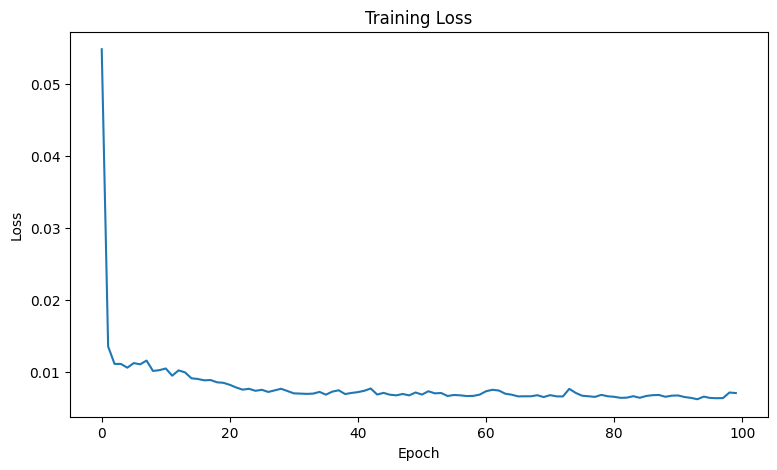

In [ ]:
# Vẽ biểu đồ
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 5))
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## Đánh giá mô hình

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Đánh giá mô hình
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

6/6 [==============================] - 1s 5ms/step
Mean Absolute Error (MAE): 0.07365642661647633
Mean Squared Error (MSE): 0.009191674732832767
R2 Score: 0.7596362197212796


In [ ]:
# Lưu kết quả vào file
results_text = f"Mean Absolute Error (MAE): {mae}\n" \
               f"Mean Squared Error (MSE): {mse}\n" \
               f"R2 Score: {r2}\n"

with open("Result_MinTempLSTM.txt", "w") as file:
    file.write(results_text)

## Vẽ biểu đồ với dữ liệu đã chuẩn hoá

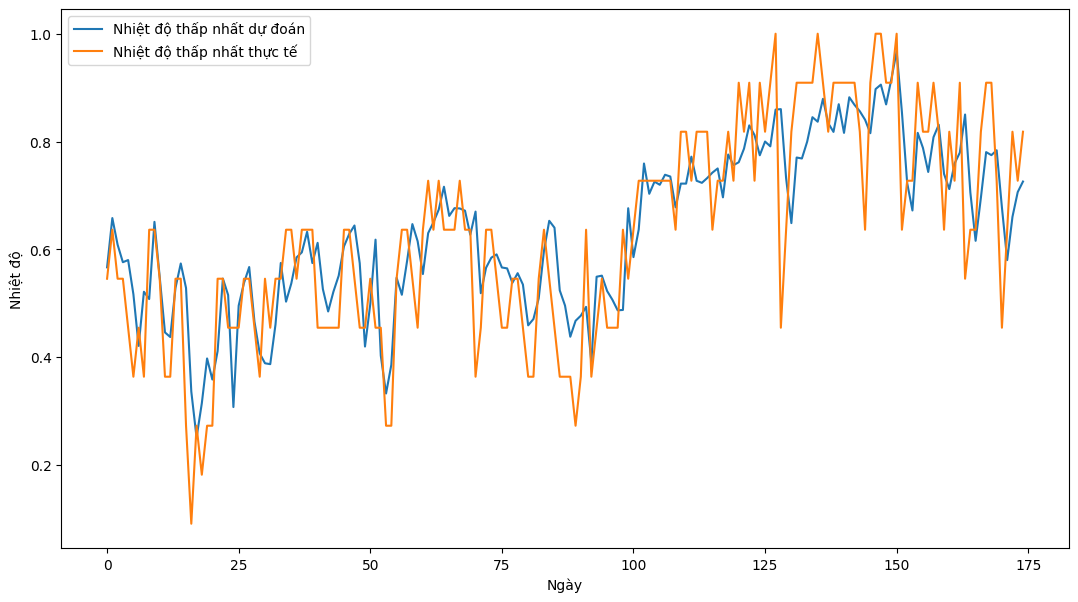

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(13, 7))
plt.plot(y_pred[:,0], label='Nhiệt độ thấp nhất dự đoán')
plt.plot(y_test[:,0], label='Nhiệt độ thấp nhất thực tế')
plt.xlabel('Ngày')
plt.ylabel('Nhiệt độ')
plt.legend()
plt.show()

## Vẽ biểu đồ với dữ liệu gốc

*Chuyển đổi dữ liệu dự đoán về dữ liệu gốc*



In [ ]:
# Dữ liệu dự đoán
import sklearn
convert = sklearn.preprocessing.MinMaxScaler()
data_maxtemp = data['MinTemperature'].values.reshape(-1,1)
convert.fit_transform(data_maxtemp)

# Chuyển đổi dữ liệu
y_pred_original = convert.inverse_transform(y_pred)

print("Dữ liệu dự đoán gốc")
y_pred_original[:10]

Dữ liệu dự đoán gốc


array([[24.232227, 22.939362, 26.200342, 26.192167],
       [25.237597, 24.2383  , 26.199312, 26.120523],
       [24.695253, 23.896067, 26.14043 , 26.078571],
       [24.337032, 23.339321, 26.151121, 26.105005],
       [24.380749, 23.507313, 25.49423 , 25.36372 ],
       [23.683487, 23.139572, 24.587078, 24.372702],
       [22.62886 , 22.357634, 23.224007, 22.597298],
       [23.734276, 22.987303, 25.555868, 25.466389],
       [23.584885, 22.697254, 24.747993, 24.300995],
       [25.160652, 24.314634, 26.314798, 26.163557]], dtype=float32)

In [ ]:
# Chuyển đổi dữ liệu
y_original = convert.inverse_transform(y_test)
print("Dữ liệu thực tế gốc")
y_original[:10]

Dữ liệu thực tế gốc


array([[24.        , 24.40659341, 26.25      , 26.20634921],
       [25.        , 23.92307692, 26.25      , 26.20634921],
       [24.        , 23.1978022 , 25.33333333, 26.20634921],
       [24.        , 23.31868132, 25.33333333, 25.50793651],
       [23.        , 22.95604396, 24.41666667, 24.1984127 ],
       [22.        , 22.35164835, 23.5       , 22.01587302],
       [23.        , 21.98901099, 24.41666667, 24.80952381],
       [22.        , 22.71428571, 25.33333333, 24.46031746],
       [25.        , 24.64835165, 26.25      , 26.46825397],
       [25.        , 23.68131868, 25.33333333, 25.24603175]])

In [ ]:
# Lưu file
df = pd.DataFrame({
    'PreMintemp': y_pred_original[:,0].flatten(),
    'ActMinTemp': y_original[:,0].flatten()
})

# Lưu DataFrame vào tệp
df.to_csv('Chart_MinLSTM.csv', index=False)

Vẽ biểu đồ so sánh dữ liệu dự đoán với dữ liệu thực tế

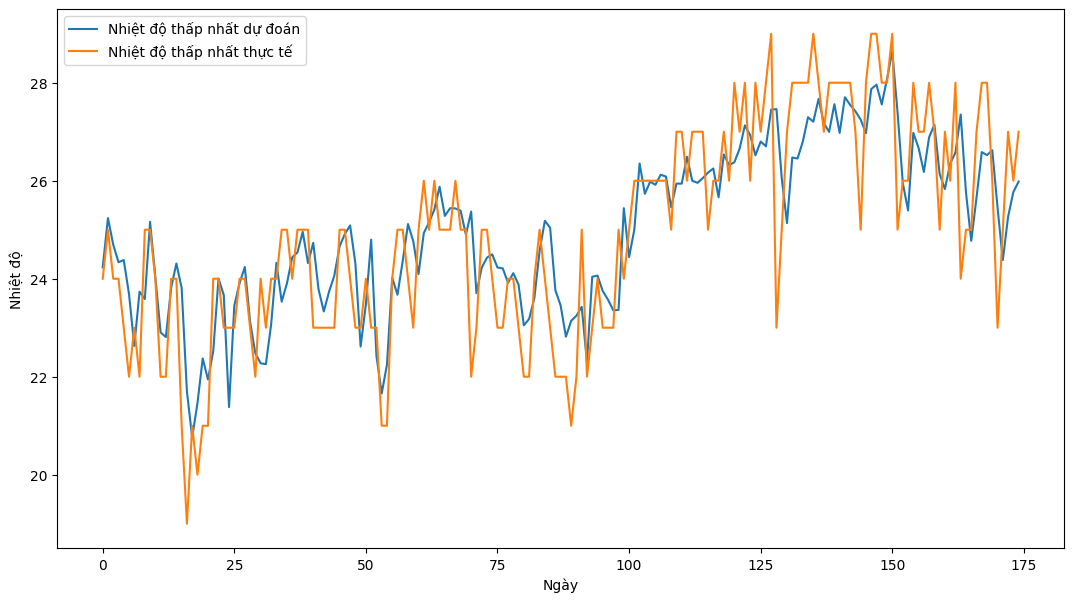

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(13, 7))
plt.plot(y_pred_original[:,0], label='Nhiệt độ thấp nhất dự đoán')
plt.plot(y_original[:,0], label='Nhiệt độ thấp nhất thực tế')
plt.xlabel('Ngày')
plt.ylabel('Nhiệt độ')
plt.legend()
plt.show()